In [1]:
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import scipy 
import sklearn.metrics

plt.style.use('seaborn-colorblind')
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.rcParams.update({'font.size': 11})

In [2]:
from platform import python_version
print(f'Python version: {python_version()}')
print(f'Scanpy version: {sc.__version__}')

Python version: 3.8.2
Scanpy version: 1.8.2


In [3]:
data_path = 'data/'

# Data Loading

In [4]:
# load raw protein dataset

filename = '20210919_DIANN_SingleCellOutput.pg_matrix_notnormalized.tsv'

cols = list(pd.read_csv(data_path + filename, nrows=1, sep='\t'))
prot = pd.read_csv(data_path + filename, usecols =[i for i in cols if 'TSCP_DIA_SingleCell' in i], sep='\t')
var_annotation = pd.read_csv(data_path + filename, index_col = 'Genes', usecols = ['Genes'], sep='\t')
prot = prot.fillna(0.)
prot[prot == 'Filtered'] = 0.

adata_prot_raw = anndata.AnnData(prot.transpose())
adata_prot_raw.var = var_annotation
adata_prot_raw.var_names = adata_prot_raw.var_names.map(str)
adata_prot_raw.var_names_make_unique()

/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
# load protein dataset with local regression normalization

filename = '20210919_DIANN_SingleCellOutput.pg_matrix_cellcyclepred.tsv'

cols = list(pd.read_csv(data_path + filename, nrows=1, sep='\t'))
prot = pd.read_csv(data_path + filename, usecols =[i for i in cols if 'TSCP_DIA_SingleCell' in i], sep='\t')
var_annotation = pd.read_csv(data_path + filename, index_col = 'Genes', usecols = ['Genes'], sep='\t')
prot[prot == 'Filtered'] = np.nan

adata_prot = anndata.AnnData(prot.transpose())
adata_prot.var = var_annotation
adata_prot.var_names = adata_prot.var_names.map(str)
adata_prot.var_names_make_unique()

protein_adata = adata_prot

In [6]:
# load data from "HeLa-CCL2 cell heterogeneity studied by single-cell DNA and RNA sequencing"
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE129447
# (SMART-Seq2 data from 9, 14 and 20 passages)

adata1 = anndata.read_text(data_path + 'GSE129447_RAW/GSM3713084_HeLa_1.txt').transpose()
adata2 = anndata.read_text(data_path + 'GSE129447_RAW/GSM3713085_HeLa_2.txt').transpose()
adata3 = anndata.read_text(data_path + 'GSE129447_RAW/GSM3713086_HeLa_3.txt').transpose()
adata3.var_names = adata1.var_names
adata2 = adata2[:, adata1.var_names] # without ERCC genes
smartseq_adata = anndata.concat([adata1, adata2, adata3])

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [7]:
# load data from "The transcriptome dynamics of single cells during the cell cycle"
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE142277

adata1_exon = anndata.read_text(data_path + 'GSE142277_RAW/GSM4224315_out_gene_exon_tagged.dge_exonssf002_WT.txt').transpose()
adata1_intron = anndata.read_text(data_path + 'GSE142277_RAW/GSM4224315_out_gene_exon_tagged.dge_intronssf002_WT.txt').transpose()
adata2_exon = anndata.read_text(data_path + 'GSE142277_RAW/GSM4224316_out_gene_exon_tagged.dge_exonssf002_KO.txt').transpose()
adata2_intron = anndata.read_text(data_path + 'GSE142277_RAW/GSM4224316_out_gene_exon_tagged.dge_intronssf002_KO.txt').transpose()

intersection = list(set(adata1_exon.var_names).intersection(adata1_intron.var_names))
intersection_part = adata1_exon[:, intersection].copy()
intersection_part.X += adata1_intron[:, intersection].X
adata1_2 = anndata.concat([
        intersection_part, 
        adata1_exon[:, [gene for gene in adata1_exon.var_names if gene not in adata1_intron.var_names]],
        adata1_intron[:, [gene for gene in adata1_intron.var_names if gene not in adata1_exon.var_names]],
    ], axis=1)

intersection = list(set(adata2_exon.var_names).intersection(adata2_intron.var_names))
intersection_part = adata2_exon[:, intersection].copy()
intersection_part.X += adata2_intron[:, intersection].X
adata2_2 = anndata.concat([
        intersection_part, 
        adata2_exon[:, [gene for gene in adata2_exon.var_names if gene not in adata2_intron.var_names]],
        adata2_intron[:, [gene for gene in adata2_intron.var_names if gene not in adata2_exon.var_names]],
    ], axis=1)

# second dataset from "The transcriptome dynamics of single cells during the cell cycle"
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4226257

adata_exon = anndata.read_text(data_path + 'GSM4226257_RAW/GSM4226257_out_gene_exon_tagged.dge_exonsds_046.txt').transpose()
adata_intron = anndata.read_text(data_path + 'GSM4226257_RAW/GSM4226257_out_gene_exon_tagged.dge_intronsds_046.txt').transpose()

intersection = list(set(adata_exon.var_names).intersection(adata_intron.var_names))
intersection_part = adata_exon[:, intersection]
intersection_part.X += adata_intron[:, intersection].X
adata1_3 = anndata.concat([
        intersection_part, 
        adata_exon[:, [gene for gene in adata_exon.var_names if gene not in adata1_intron.var_names]],
        adata_intron[:, [gene for gene in adata_intron.var_names if gene not in adata1_exon.var_names]],
    ], axis=1)
adata1_3.var_names_make_unique()

tenx_adata = anndata.concat([adata1_2, adata2_2, adata1_3], join='outer', fill_value=0.)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


## True Single-Cell Proteomics - Cell Cycle Analysis

### Fig. 4C - Total protein signal per cell grouped by cell cycle stage

In [8]:
adata_raw = adata_prot_raw.copy()
sc.pp.filter_cells(adata_raw, min_genes=600)
sc.pp.filter_genes(adata_raw, min_cells=0.15 * adata_raw.shape[0])

adata_raw.obs['cell cycle stage'] = [
    'G1' if '_G1_' in name
    else 'G1-S' if '_TB_' in name
    else 'G2' if '_G2_' in name
    else 'G2-M' if '_NB_' in name
    else 'other'
    for name in adata_raw.obs_names
]

/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


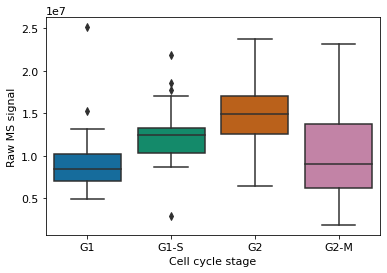

In [9]:
size = {cond: adata_raw[adata_raw.obs['cell cycle stage'] == cond].X.sum(axis=1)
       for cond in ['G1', 'G1-S', 'G2', 'G2-M']}
x = np.concatenate([[cond] * len(cells) for cond, cells in size.items()])
y = np.concatenate([cells for cells in size.values()])
sns.boxplot(x, y)
plt.xlabel("Cell cycle stage")
plt.ylabel("Raw MS signal")
plt.show()

In [10]:
for cond, d in size.items():
    print(f'{cond}:\t n = {len(d)},\t median = {np.median(d)}')

G1:	 n = 84,	 median = 8477524.0
G1-S:	 n = 41,	 median = 12429287.0
G2:	 n = 52,	 median = 14910479.0
G2-M:	 n = 45,	 median = 9016382.0


### Fig. 4D - Principal Component Analysis

In [11]:
def impute_downshifted_normal_global(
        adata,
        scale=0.3,
        shift=1.8,
):
    np.random.seed(42)
    mean = np.nanmean(adata.X)
    std = np.nanstd(adata.X)
    draws = np.random.normal(loc=mean - shift * std, scale=scale * std, size=np.sum(np.isnan(adata.X)))
    adata.X[np.isnan(adata.X)] = draws

In [12]:
adata = protein_adata.copy()
sc.pp.filter_cells(adata, min_genes=600)
sc.pp.filter_genes(adata, min_cells=0.15 * adata.shape[0])
sc.pp.log1p(adata)
impute_downshifted_normal_global(adata)

adata.obs['cell cycle stage'] = [
    'G1' if '_G1_' in name
    else 'G1-S' if '_TB_' in name
    else 'G2' if '_G2_' in name
    else 'G2-M' if '_NB_' in name
    else 'other'
    for name in adata.obs_names
]
adata = adata[adata.obs['cell cycle stage'] != 'other']

/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'cell cycle stage' as categorical


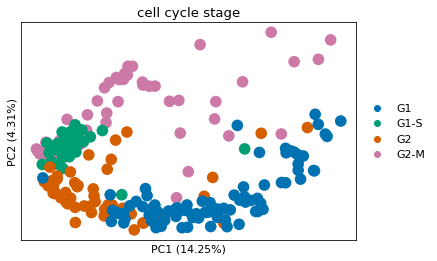

In [13]:
sc.pp.pca(adata)
sc.pl.pca(adata, color='cell cycle stage', annotate_var_explained=True)
plt.show()

### Fig. 4E - Cell cycle stage prediction 

In [14]:
adata = protein_adata.copy()
sc.pp.filter_cells(adata, min_genes=600)
sc.pp.filter_genes(adata, min_cells=0.7 * adata.shape[0])
sc.pp.log1p(adata)
adata.X = np.nan_to_num(adata.X)

adata.obs['cell cycle stage'] = [
    'G1' if '_G1_' in name
    else 'G1-S' if '_TB_' in name
    else 'G2' if '_G2_' in name
    else 'G2-M' if '_NB_' in name
    else 'other'
    for name in adata.obs_names
]
adata = adata[adata.obs['cell cycle stage'] != 'other']

/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [15]:
cc_markers = pd.read_excel("CellCycleMarker.xlsx", "Tami_Geiger")

g1_list = cc_markers['G1'][1:-1]
g1_list = [g for g in g1_list if g in adata.var_names]
print(f'G1:\t {", ".join(g1_list)}')

s_list = cc_markers['S'][1:-1]
s_list = [g for g in s_list if g in adata.var_names]
print(f'S:\t {", ".join(s_list)}')

g2m_list = cc_markers['G2M'][1:-1]
g2m_list = [g for g in g2m_list if g in adata.var_names]
print(f'G2M:\t {", ".join(g2m_list)}')

G1:	 MARCKS, KRT1, HIST1H1E, KRT18, HNRNPA1, CHCHD3, CD44, NASP, TARDBP, PODXL, SUMO2, STMN1, TRIM28, SPTAN1
S:	 NOLC1, ATP2A2, CANX, TMX1, CKB, SLC25A3, SLC16A1, MT-CO2, SRPRB, CYB5R3, LETM1, ANP32B
G2M:	 TOP2A, HMGB1, EIF5B, TMSB10, EIF3D, ANP32A, RCC2, FASN, LUC7L2, AARS, KPNA2, CKAP5


In [16]:
sc.tl.score_genes(adata, g1_list, score_name='g1')
sc.tl.score_genes(adata, s_list, score_name='s')
sc.tl.score_genes(adata, g2m_list, score_name='g2m')

Trying to set attribute `.obs` of view, copying.


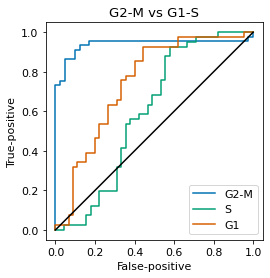

In [17]:
protein_data_nb_tb = adata[np.array(adata.obs['cell cycle stage'] == 'G2-M') 
                                  | np.array(adata.obs['cell cycle stage'] == 'G1-S')]

score = {
    'G2-M': protein_data_nb_tb.obs['g2m'].values,
    'S': protein_data_nb_tb.obs['s'].values,
    'G1': protein_data_nb_tb.obs['g1'].values
}

for phase in score.keys():
    true_label = np.array([phase in a for a in protein_data_nb_tb.obs['cell cycle stage'].values])
    scores = score[phase]
    fp, tp, _ = sklearn.metrics.roc_curve(true_label, scores)
    plt.plot(fp, tp, label=phase)
plt.plot([0, 1], [0, 1], c='black')
plt.gca().set_aspect('equal')
plt.xlabel('False-positive')
plt.ylabel('True-positive')
plt.legend()
plt.title('G2-M vs G1-S')
plt.show()

In [18]:
for phase in score.keys():
    true_label = np.array([phase in a for a in protein_data_nb_tb.obs['cell cycle stage'].values])
    scores = score[phase]
    print(f'AUC using the {phase} score: {sklearn.metrics.roc_auc_score(true_label, scores):.2f}')

AUC using the G2-M score: 0.94
AUC using the S score: 0.60
AUC using the G1 score: 0.74


## True Single-Cell Proteomics - Comparison with Transcriptomics Data

### Fig. 5A - Gene expression completeness within cells

In [19]:
full_data = {
    'Proteins': protein_adata.copy(), 
    'SMARTseq2': smartseq_adata.copy(),
    'Drop-Seq': tenx_adata.copy(),
}

for adata in full_data.values():
    sc.pp.filter_cells(adata, min_genes=600)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [20]:
for datasetname, adata in full_data.items():
    print(f'{datasetname}\t {adata.shape},\t mean completeness per cell: {np.median((adata.X > 0).mean(axis=1)):.2f}')

Proteins	 (424, 2480),	 mean completeness per cell: 0.49
SMARTseq2	 (720, 24990),	 mean completeness per cell: 0.28
Drop-Seq	 (5022, 41161),	 mean completeness per cell: 0.07


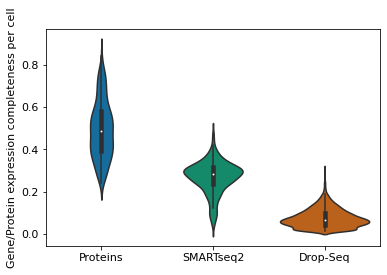

In [21]:
perc_expr = []
dataset_name = []
for datasetname, adata in full_data.items():
    perc_expr += list((adata.X > 0).mean(axis=1))
    dataset_name += [datasetname] * adata.X.shape[0]
sns.violinplot(y=perc_expr, x=dataset_name)
plt.ylabel('Gene/Protein expression completeness per cell')
plt.show()

### Fig. 5B - Principal Component Analysis

In [22]:
full_data = {
    'Proteins': protein_adata.copy(), 
    'SMART-Seq2': smartseq_adata.copy(),
    'Drop-Seq': tenx_adata.copy(),
}

for adata in full_data.values():
    sc.pp.filter_cells(adata, min_genes=600)
    sc.pp.filter_genes(adata, min_cells=0.15 * adata.shape[0])
    
shared_genes = set(full_data['Proteins'].var_names)
for adata in full_data.values():
    shared_genes = shared_genes.intersection(adata.var_names)
    
intersection_data = {
    datasetname: adata[:, list(shared_genes)]
    for datasetname, adata in full_data.items()
}
    
for adata in intersection_data.values():
    adata.X = np.nan_to_num(adata.X)
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.log1p(adata.X)
    
for datasetname, adata in intersection_data.items():
    adata.obs['dataset'] = datasetname
joined = anndata.concat([adata for adata in intersection_data.values()])

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are no

In [23]:
intersection_data

{'Proteins': AnnData object with n_obs × n_vars = 424 × 1672
     obs: 'n_genes', 'dataset'
     var: 'n_cells',
 'SMART-Seq2': AnnData object with n_obs × n_vars = 720 × 1672
     obs: 'n_genes', 'dataset'
     var: 'n_cells',
 'Drop-Seq': AnnData object with n_obs × n_vars = 5022 × 1672
     obs: 'n_genes', 'dataset'
     var: 'n_cells'}

/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'dataset' as categorical


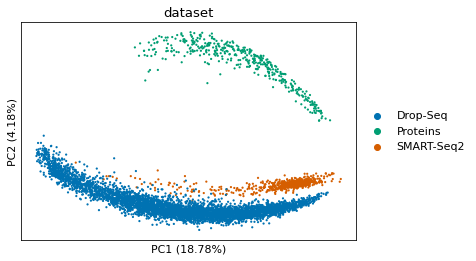

In [24]:
sc.pp.pca(joined)
ax = sc.pl.pca(joined, color='dataset', show=False, annotate_var_explained=True)
ax.invert_xaxis()
plt.show()

### Fig. 5C - Pearson Correlation Analysis

In [25]:
full_data = {
    'Proteins': protein_adata.copy(), 
    'SMART-Seq2': smartseq_adata.copy(),
    'Drop-Seq': tenx_adata.copy(),
}

for adata in full_data.values():
    sc.pp.filter_cells(adata, min_genes=600)
    sc.pp.filter_genes(adata, min_cells=0.15 * adata.shape[0])

for name, adata in full_data.items():
    if name != 'Proteins':
        sc.pp.normalize_total(adata, target_sum=np.mean(np.nansum(adata.X, axis=1)))
    sc.pp.log1p(adata.X)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [26]:
for adata in full_data.values():
    np.random.shuffle(adata.X)

joined = anndata.concat(full_data.values()) # performs inner join
dataset_names = np.concatenate([[name] * adata.shape[0] for name, adata in full_data.items()])
print('number of shared genes:', joined.shape[1])

c = np.array(pd.DataFrame(joined.X.T).corr())

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


number of shared genes: 1672


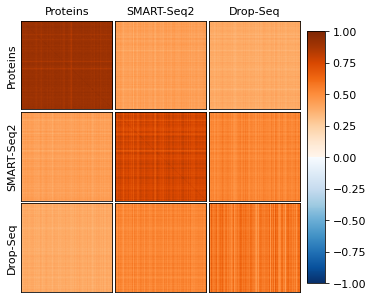

In [27]:
top = cm.get_cmap('Blues_r', 128)
bottom = cm.get_cmap('Oranges', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

fig, ax = plt.subplots(3, 3, figsize=(5,5), gridspec_kw=dict(wspace=.03, hspace=.03))
for i, dataset_1 in enumerate(full_data.keys()):
    for j, dataset_2 in enumerate(full_data.keys()):
        subdata = c[dataset_names == dataset_1][:, dataset_names == dataset_2]
        color_obj = ax[i, j].imshow(subdata, vmin=-1, vmax=1, aspect='auto', cmap=newcmp)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        if i == 0:
            ax[i, j].set_title(dataset_2, fontsize=11)
        if j == 0:
            ax[i, j].set_ylabel(dataset_1, fontsize=11)

cbar_ax = fig.add_axes([.92, 0.15, 0.05, .7])
plt.colorbar(color_obj, cax=cbar_ax)
plt.show()

### Fig. 5D - Variance analysis

In [28]:
adata = protein_adata.copy()
sc.pp.filter_cells(adata, min_genes=600)
sc.pp.filter_genes(adata, min_cells=0.15 * adata.shape[0])

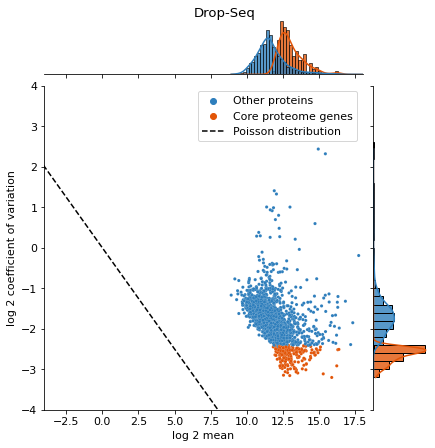

In [29]:
dir_core_proteome = 'CoreProteome.txt'
core_proteins = list(pd.read_csv(dir_core_proteome, sep='\t')['Genes'])

color = {
    'Core proteome genes': newcmp(.85),
    'Other proteins': newcmp(0.15)
}
adata.var['core/noncore'] = [
    'Core proteome genes' if prot in core_proteins 
    else 'Other proteins' 
    for prot in adata.var_names
]
mean = np.nanmean(adata.X, axis=0)
coeff_of_var = scipy.stats.variation(adata.X, nan_policy='omit').data

g = sns.JointGrid(
    x=np.log2(mean),
    y=np.log2(coeff_of_var),
    hue=adata.var['core/noncore'],
    palette=color,
)
g.plot_joint(
    sns.scatterplot, 
    s=10, 
    alpha=1,
    linewidth=.1
)
g.plot_marginals(
    sns.histplot, 
    kde=True, 
    stat='density', 
    common_norm=False,
    binwidth=.2,
    alpha=.8
)
g.ax_joint.set_xlabel('log 2 mean')
g.ax_joint.set_ylabel('log 2 coefficient of variation')
g.ax_joint.set_xlim(-4, 18)
g.ax_joint.set_ylim(-4, 4)
g.ax_joint.plot([-6, 10], [3, -5], '--',c='black', label='Poisson distribution')
g.ax_joint.legend(title=[])
plt.suptitle(datasetname, y=1)
plt.show()

### Fig. 5E - Variance comparison

In [30]:
full_data = {
    'Proteins': protein_adata.copy(), 
    'SMART-Seq2': smartseq_adata.copy(),
    'Drop-Seq': tenx_adata.copy(),
}

for adata in full_data.values():
    sc.pp.filter_cells(adata, min_genes=600)
    sc.pp.filter_genes(adata, min_cells=0.15 * adata.shape[0])

for name, adata in full_data.items():
    if name != 'Proteins':
        sc.pp.normalize_total(adata, target_sum=np.mean(np.nansum(adata.X, axis=1)))

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


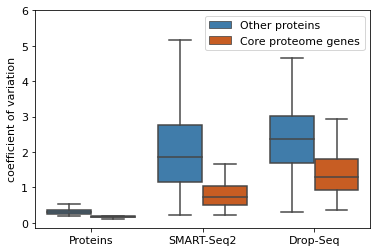

In [31]:
cov = []
hue = []
dataset_name = []

for datasetname, adata in full_data.items():
    adata.var['core/noncore'] = ['Core proteome genes' if prot in core_proteins else 'Other proteins' for prot in adata.var_names]
    mean = np.nanmean(adata.X, axis=0)
    coeff_of_var = scipy.stats.variation(adata.X, nan_policy='omit').data
    cov += list(coeff_of_var)
    hue += list(adata.var['core/noncore'])
    dataset_name += [datasetname] * adata.shape[1]

sns.boxplot(
    x = dataset_name, 
    y=cov, 
    hue=hue,
    palette=color,
    showfliers=False,
)
plt.ylabel('coefficient of variation')
plt.ylim(top=6)
plt.show()

## Supplementary Analyses

### Effect of Local Regression Normalisation

In [32]:
adata_normalised = protein_adata.copy()
sc.pp.filter_cells(adata_normalised, min_genes=600)
sc.pp.filter_genes(adata_normalised, min_cells=0.15 * adata_normalised.shape[0])
sc.pp.log1p(adata_normalised)
adata_normalised.X = np.nan_to_num(adata_normalised.X)

adata_raw = adata_prot_raw.copy()
sc.pp.filter_cells(adata_raw, min_genes=600)
sc.pp.filter_genes(adata_raw, min_cells=0.15 * adata_raw.shape[0])
sc.pp.log1p(adata_raw)
adata_raw.X = np.nan_to_num(adata_raw.X)

/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


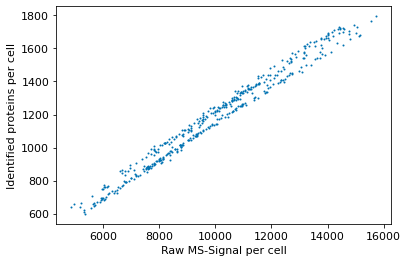

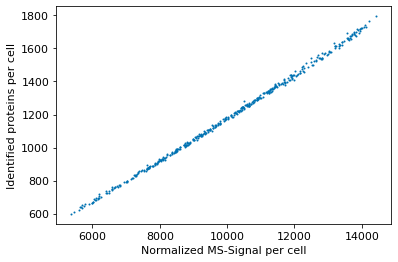

In [33]:
x = adata_raw.X.sum(axis=1)
y = (adata_raw.X > 0).sum(axis=1)
plt.scatter(x, y, s=1)
plt.xlabel('Raw MS-Signal per cell')
plt.ylabel('Identified proteins per cell')
plt.show()

x = adata_normalised.X.sum(axis=1)
y = (adata_normalised.X > 0).sum(axis=1)
plt.scatter(x, y, s=1)
plt.xlabel('Normalized MS-Signal per cell')
plt.ylabel('Identified proteins per cell')
plt.show()

### PCA including untreated cells

In [34]:
adata = protein_adata.copy()
sc.pp.filter_cells(adata, min_genes=600)
sc.pp.filter_genes(adata, min_cells=0.15 * adata.shape[0])
sc.pp.log1p(adata)
impute_downshifted_normal_global(adata)

adata.obs['condition'] = [
    'G1' if '_G1_' in name
    else 'G1-S' if '_TB_' in name
    else 'G2' if '_G2_' in name
    else 'G2-M' if '_NB_' in name
    else 'UB_Passage01' if 'UB' in name and '20201010' in name
    else 'UB_Passage02_Plate01' if 'UB' in name and int(name.split('_')[16].split('.')[0]) < 5050
    else 'UB_Passage02_Plate02'
    for name in adata.obs_names
]

/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'condition' as categorical


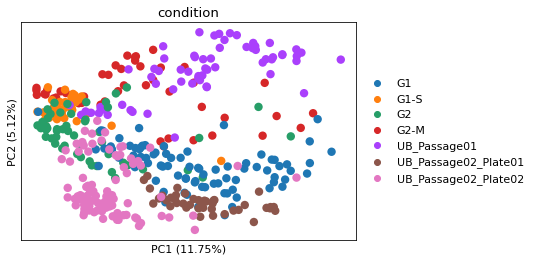

In [35]:
sc.pp.pca(adata)
sc.pl.pca(adata, color='condition', annotate_var_explained=True)
plt.show()

### Cell cycle stage prediction

In [36]:
adata = protein_adata.copy()
sc.pp.filter_cells(adata, min_genes=600)
sc.pp.filter_genes(adata, min_cells=0.7 * adata.shape[0])
sc.pp.log1p(adata)
adata.X = np.nan_to_num(adata.X)

adata.obs['cell cycle stage'] = [
    'G1' if '_G1_' in name
    else 'G1-S' if '_TB_' in name
    else 'G2' if '_G2_' in name
    else 'G2-M' if '_NB_' in name
    else 'other'
    for name in adata.obs_names
]
adata = adata[adata.obs['cell cycle stage'] != 'other']

/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [37]:
cc_markers = pd.read_excel("CellCycleMarker.xlsx", "Tami_Geiger")

g1_list = cc_markers['G1'][1:-1]
g1_list = [g for g in g1_list if g in adata.var_names]
print(f'G1:\t {", ".join(g1_list)}')

s_list = cc_markers['S'][1:-1]
s_list = [g for g in s_list if g in adata.var_names]
print(f'S:\t {", ".join(s_list)}')

g2m_list = cc_markers['G2M'][1:-1]
g2m_list = [g for g in g2m_list if g in adata.var_names]
print(f'G2M:\t {", ".join(g2m_list)}')

G1:	 MARCKS, KRT1, HIST1H1E, KRT18, HNRNPA1, CHCHD3, CD44, NASP, TARDBP, PODXL, SUMO2, STMN1, TRIM28, SPTAN1
S:	 NOLC1, ATP2A2, CANX, TMX1, CKB, SLC25A3, SLC16A1, MT-CO2, SRPRB, CYB5R3, LETM1, ANP32B
G2M:	 TOP2A, HMGB1, EIF5B, TMSB10, EIF3D, ANP32A, RCC2, FASN, LUC7L2, AARS, KPNA2, CKAP5


In [38]:
sc.tl.score_genes(adata, g1_list, score_name='g1')
sc.tl.score_genes(adata, s_list, score_name='s')
sc.tl.score_genes(adata, g2m_list, score_name='g2m')

Trying to set attribute `.obs` of view, copying.


AUC using the G2-M score: 0.46
AUC using the S score: 0.35
AUC using the G1 score: 0.67


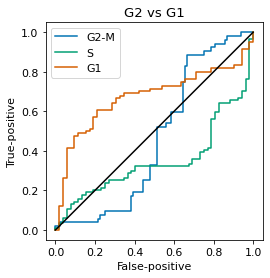

AUC using the G2-M score: 0.66


/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AUC using the S score: 0.52
AUC using the G1 score: 0.84


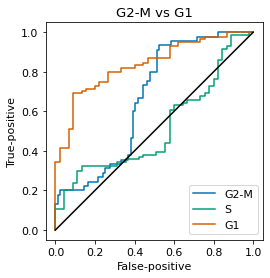

In [39]:
for pair in [('G2', 'G1'), ('G2-M', 'G1')]:
    data_comparison = adata[np.array(adata.obs['cell cycle stage'] == pair[0]) 
                                      | np.array(adata.obs['cell cycle stage'] == pair[1])]

    score = {}
    score['G2-M'] = data_comparison.obs['g2m'].values
    score['S'] = data_comparison.obs['s'].values
    score['G1'] = data_comparison.obs['g1'].values
    
    for phase in score.keys():
        true_label = np.array([phase in a or (phase == 'S' and a == 'G1') or a in phase for a in data_comparison.obs['cell cycle stage'].values])
        scores = score[phase]
        print(f'AUC using the {phase} score: {sklearn.metrics.roc_auc_score(true_label, scores):.2f}')
        fp, tp, _ = sklearn.metrics.roc_curve(true_label, scores)
        plt.plot(fp, tp, label=phase)
    plt.plot([0, 1], [0, 1], c='black')
    plt.gca().set_aspect('equal')
    plt.xlabel('False-positive')
    plt.ylabel('True-positive')
    plt.legend()
    plt.title(f'{pair[0]} vs {pair[1]}')
    plt.show()

### Data completeness

In [40]:
full_data = {
    'Proteins': protein_adata.copy(), 
    'SMART-Seq2': smartseq_adata.copy(),
    'Drop-Seq': tenx_adata.copy(),
}

for adata in full_data.values():
    sc.pp.filter_cells(adata, min_genes=600)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Proteins (424, 2447)
SMART-Seq2 (720, 2447)
Drop-Seq (5022, 2447)


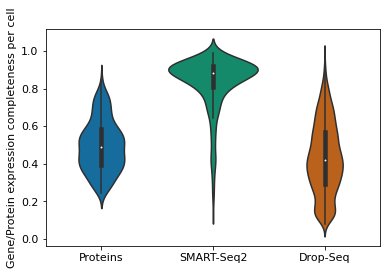

In [41]:
shared_genes = set(full_data['Proteins'].var_names)
for adata in full_data.values():
    shared_genes = shared_genes.intersection(adata.var_names)
    
intersection_data = {
    datasetname: adata[:, list(shared_genes)]
    for datasetname, adata in full_data.items()
}

perc_expr = []
dataset_name = []
for datasetname, adata in intersection_data.items():
    print(f'{datasetname} {adata.shape}')
    perc_expr += list((adata.X > 0).mean(axis=1))
    dataset_name += [datasetname] * adata.X.shape[0]
sns.violinplot(y=perc_expr, x=dataset_name)
plt.ylabel('Gene/Protein expression completeness per cell')
plt.show()

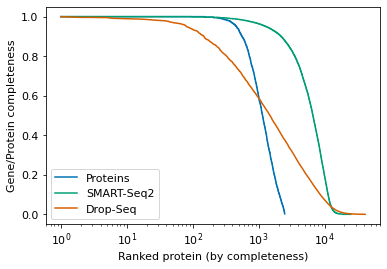

In [42]:
for name, adata in full_data.items():
    completeness = (adata.X > 0).sum(axis=0) / adata.X.shape[0]
    sorted_completeness = np.sort(completeness)[::-1]
    plt.plot(np.arange(len(sorted_completeness)) + 1, sorted_completeness, label=name)

plt.legend()
plt.ylabel('Gene/Protein completeness')
plt.xlabel('Ranked protein (by completeness)')
plt.xscale("log")
plt.show()

<ipython-input-43-a69cb3e7f1f8>:4: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(x), y, s=1, label=datasetname)
<ipython-input-43-a69cb3e7f1f8>:8: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(x2), 1-np.exp(-x2), c='black', label='expected poisson dropout')


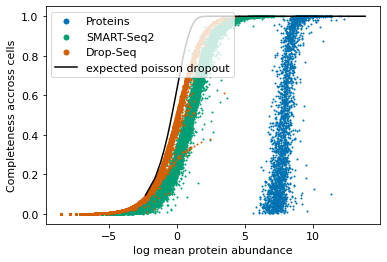

In [43]:
for datasetname, adata in full_data.items():
    x = np.nanmean(adata.X, axis=0)
    y = np.nanmean(adata.X > 0, axis=0)
    plt.scatter(np.log(x), y, s=1, label=datasetname)
    
# Pois(0) = exp(-mean) -> prob for k zeros in n cells = Binom(k|p, n), with expectation p*n -> divide by n
x2 = np.arange(0, 1000000, 0.1)
plt.plot(np.log(x2), 1-np.exp(-x2), c='black', label='expected poisson dropout')
plt.xlabel('log mean protein abundance')
plt.ylabel('Completeness accross cells')
plt.legend(markerscale=5., loc='upper left')
plt.show()

### Variance analyses

In [44]:
full_data = {
    'Proteins': protein_adata.copy(), 
    'SMART-Seq2': smartseq_adata.copy(),
    'Drop-Seq': tenx_adata.copy(),
}

for adata in full_data.values():
    sc.pp.filter_cells(adata, min_genes=600)
    sc.pp.filter_genes(adata, min_cells=0.15 * adata.shape[0])

for name, adata in full_data.items():
    print(name, np.mean(np.nansum(adata.X, axis=1)))
    if name != 'Proteins':
        sc.pp.normalize_total(adata, target_sum=np.mean(np.nansum(adata.X, axis=1)))

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Proteins 9631877.0
SMART-Seq2 231281.56
Drop-Seq 7808.1196


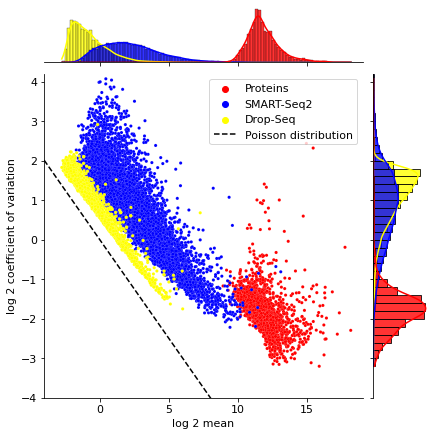

In [45]:
mean = []
coeff_of_var = []
name = []
for datasetname, adata in full_data.items():
    data = adata.X.copy()
    mean += list(np.nanmean(data, axis=0))
    coeff_of_var +=  list(scipy.stats.variation(data, nan_policy='omit').data)
    name += [datasetname] * len(np.nanmean(data, axis=0))
    
color = {
    'Proteins': 'red',
    'SMART-Seq2': 'blue',
    'Drop-Seq': 'yellow',
}

g = sns.JointGrid(
    x=np.log2(mean),
    y=np.log2(coeff_of_var),
    hue=name,
    palette=color,
)
g.plot_joint(
    sns.scatterplot, 
    s=10, 
    alpha=1,
    linewidth=.1
)
g.plot_marginals(
    sns.histplot, 
    kde=True, 
    stat='density', 
    common_norm=False,
    binwidth=.2,
    alpha=.8
)
g.ax_joint.set_xlabel('log 2 mean')
g.ax_joint.set_ylabel('log 2 coefficient of variation')
g.ax_joint.set_xlim(-4, 19)
g.ax_joint.set_ylim(-4, 4.2)
g.ax_joint.plot([-6, 10], [3, -5], '--',c='black', label='Poisson distribution')
g.ax_joint.legend(title=[])
plt.show()

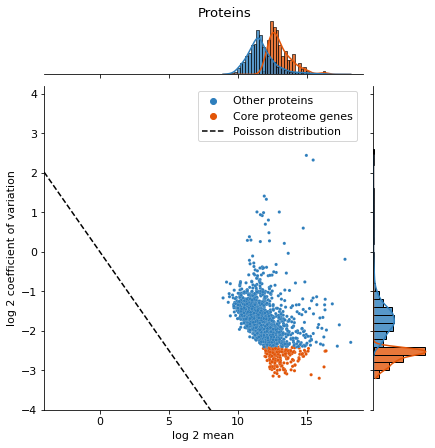

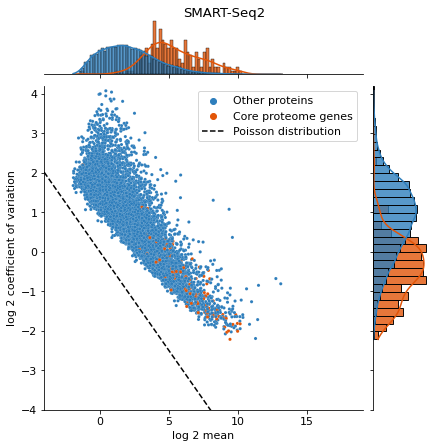

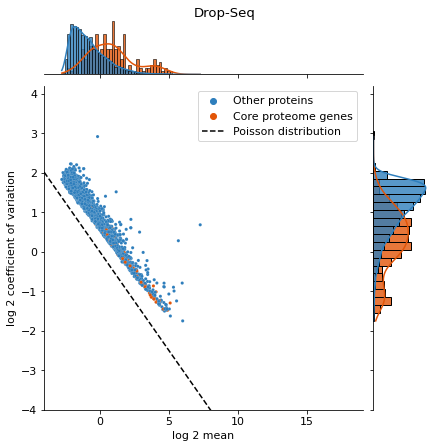

In [46]:
dir_core_proteome = 'CoreProteome.txt'
core_proteins = list(pd.read_csv(dir_core_proteome, sep='\t')['Genes'])

cov = []
hue = []
dataset_name = []
color = {
    'Core proteome genes': newcmp(.85),
    'Other proteins': newcmp(0.15)
}

for datasetname, adata in full_data.items():    
    adata.var['core/noncore'] = ['Core proteome genes' if prot in core_proteins else 'Other proteins' for prot in adata.var_names]
    mean = np.nanmean(adata.X, axis=0)
    coeff_of_var = scipy.stats.variation(adata.X, nan_policy='omit').data
    cov += list(coeff_of_var)
    hue += list(adata.var['core/noncore'])
    g = sns.JointGrid(
        x=np.log2(mean),
        y=np.log2(coeff_of_var),
        hue=adata.var['core/noncore'],
        palette=color,
    )
    g.plot_joint(
        sns.scatterplot, 
        s=10, 
        alpha=1,
        linewidth=.1
    )
    g.plot_marginals(
        sns.histplot, 
        kde=True, 
        stat='density', 
        common_norm=False,
        binwidth=.2,
        alpha=.8
    )
    g.ax_joint.set_xlabel('log 2 mean')
    g.ax_joint.set_ylabel('log 2 coefficient of variation')
    g.ax_joint.set_xlim(-4, 19)
    g.ax_joint.set_ylim(-4, 4.2)
    g.ax_joint.plot([-6, 10], [3, -5], '--',c='black', label='Poisson distribution')
    g.ax_joint.legend(title=[])
    plt.suptitle(datasetname, y=1)
    plt.show()

In [47]:
inter = set(full_data['Proteins'].var_names)
for adata in full_data.values():
    inter = inter.intersection(adata.var_names)

intersection_data = {}
for datasetname, adata in full_data.items():
    intersection_data[datasetname] = adata[:, list(inter)]

cvs = {}
for datasetname, adata in intersection_data.items():
    cvs[datasetname] = scipy.stats.variation(adata.X, nan_policy='omit').data

/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


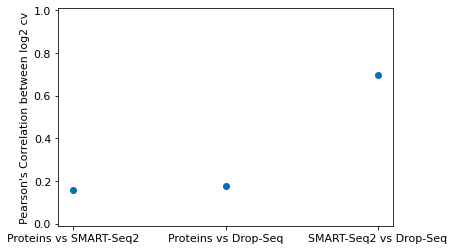

In [48]:
x = []
y = []
for pair in [('Proteins', 'SMART-Seq2'), ('Proteins', 'Drop-Seq'), ('SMART-Seq2', 'Drop-Seq')]:
    r = scipy.stats.pearsonr(np.log2(cvs[pair[0]]), np.log2(cvs[pair[1]]))[0]
    x.append(f'{pair[0]} vs {pair[1]}')
    y.append(r)

plt.scatter(
    x=x, 
    y=y,
)
plt.ylabel('Pearson\'s Correlation between log2 cv')
plt.ylim(-0.01, 1.01)
plt.show()

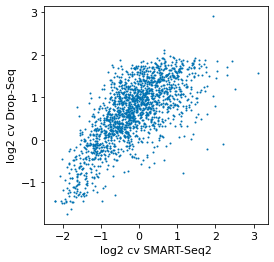

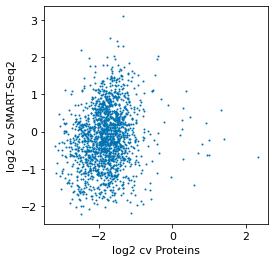

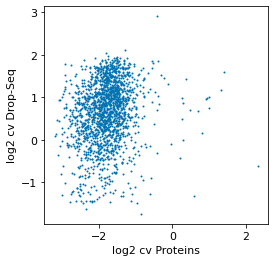

In [49]:
for pair in [('SMART-Seq2', 'Drop-Seq'), ('Proteins', 'SMART-Seq2'), ('Proteins', 'Drop-Seq')]:
    plt.figure(figsize=(4,4))
    plt.scatter(np.log2(cvs[pair[0]]), np.log2(cvs[pair[1]]), s=1)
    plt.xlabel(f'log2 cv {pair[0]}')
    plt.ylabel(f'log2 cv {pair[1]}')
    plt.show()

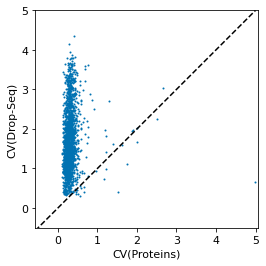

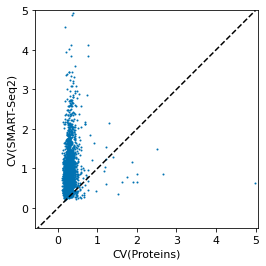

In [50]:
for pair in [('Proteins', 'Drop-Seq'), ('Proteins', 'SMART-Seq2')]:
    plt.figure(figsize=(4,4))
    plt.scatter(cvs[pair[0]], cvs[pair[1]], s=1)
    plt.xlabel(f'CV({pair[0]})')
    plt.ylabel(f'CV({pair[1]})')
    plt.plot([-1, 5], [-1, 5], '--', c='black')
    plt.axis('equal')
    plt.gca().set_ylim(-.5, 5)
    plt.gca().set_xlim(-.5, 5)
    plt.show()

### Correlation analyses

In [51]:
full_data = {
    'Proteins': protein_adata.copy(), 
    'SMART-Seq2': smartseq_adata.copy(),
    'Drop-Seq': tenx_adata.copy(),
}

for adata in full_data.values():
    sc.pp.filter_cells(adata, min_genes=600)
    sc.pp.filter_genes(adata, min_cells=0.15 * adata.shape[0])

for name, adata in full_data.items():
    if name != 'Proteins':
        sc.pp.normalize_total(adata, target_sum=np.mean(np.nansum(adata.X, axis=1)))
    sc.pp.log1p(adata.X)
    
shared_genes = set(full_data['Proteins'].var_names)
for adata in full_data.values():
    shared_genes = shared_genes.intersection(adata.var_names)

intersection_data = {}
for datasetname, adata in full_data.items():
    intersection_data[datasetname] = adata[:, list(shared_genes)]

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


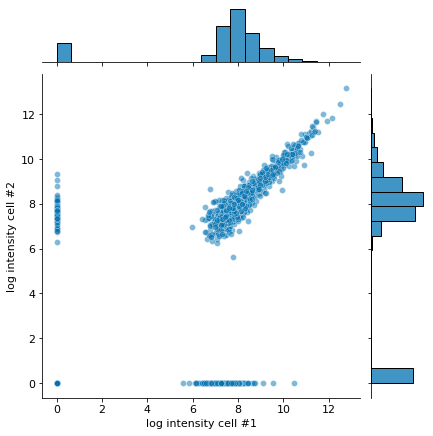

In [52]:
cell1 = np.nan_to_num(full_data['Proteins'].X[14, :].copy())
cell2 = np.nan_to_num(full_data['Proteins'].X[15, :].copy())

grid = sns.jointplot(cell1, cell2, alpha=0.5, marginal_kws={'bins': 20})
grid.set_axis_labels('log intensity cell #1', 'log intensity cell #2')
plt.show()

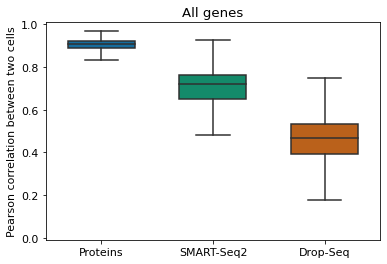

In [53]:
r_values = []
data_type = []

for datasetname, adata in full_data.items():
    r = np.array(pd.DataFrame(adata.X).T.corr())
    np.fill_diagonal(r, np.nan)
    r_vals = [val for val in r.flatten() if not np.isnan(val)]
    r_values += r_vals
    data_type += [datasetname] * len(r_vals)

r_vals = np.array(r_values)
for datasetname in full_data.keys():
    corrs = r_vals[np.array(data_type) == datasetname]

ax = sns.boxplot(
    x=data_type,
    y=r_values,
    width=0.6,
    showfliers=False,
)        
ax.set_ylabel("Pearson correlation between two cells")
plt.ylim(-0.01, 1.01)
plt.title('All genes')
plt.show()

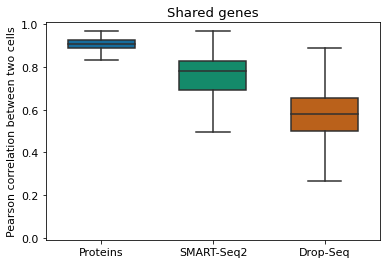

In [54]:
r_values = []
data_type = []

for datasetname, adata in intersection_data.items():
    r = np.array(pd.DataFrame(adata.X).T.corr())
    np.fill_diagonal(r, np.nan)
    r_vals = [val for val in r.flatten() if not np.isnan(val)]
    r_values += r_vals
    data_type += [datasetname] * len(r_vals)

r_vals = np.array(r_values)
for datasetname in full_data.keys():
    corrs = r_vals[np.array(data_type) == datasetname]

ax = sns.boxplot(
    x=data_type,
    y=r_values,
    width=0.6,
    showfliers=False,
)        
ax.set_ylabel("Pearson correlation between two cells")
plt.ylim(-0.01, 1.01)
plt.title('Shared genes')
plt.show()

### Abundance value distributions

In [55]:
full_data = {
    'Proteins': protein_adata.copy(), 
    'SMART-Seq2': smartseq_adata.copy(),
    'Drop-Seq': tenx_adata.copy(),
}

for adata in full_data.values():
    sc.pp.log1p(adata.X)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


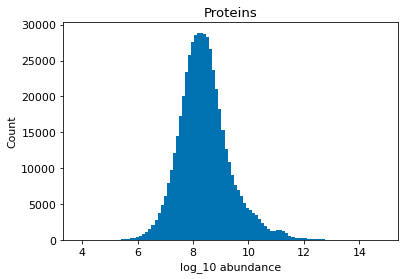

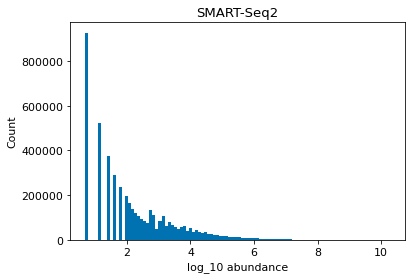

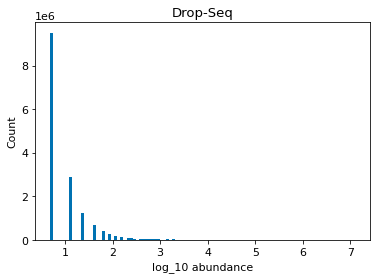

In [56]:
for name, adata in full_data.items():
    vals = adata.X.flatten()
    vals = vals[vals != 0]
    plt.hist(vals, bins=100)
    plt.title(name)
    plt.xlabel('log_10 abundance')
    plt.ylabel('Count')
    plt.show()

### Data before and after filtering

In [57]:
full_data = {
    'Proteins': protein_adata.copy(), 
    'SMART-Seq2': smartseq_adata.copy(),
    'Drop-Seq': tenx_adata.copy(),
}
print('Before filtering:')
full_data

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Before filtering:


{'Proteins': AnnData object with n_obs × n_vars = 434 × 2480,
 'SMART-Seq2': AnnData object with n_obs × n_vars = 720 × 24990,
 'Drop-Seq': AnnData object with n_obs × n_vars = 5665 × 41161}

In [58]:
for adata in full_data.values():
    sc.pp.filter_cells(adata, min_genes=600)
    sc.pp.filter_genes(adata, min_cells=0.15 * adata.shape[0])
print('After filtering:')
full_data

/Users/sabrina.richter/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


After filtering:


{'Proteins': AnnData object with n_obs × n_vars = 424 × 1867
     obs: 'n_genes'
     var: 'n_cells',
 'SMART-Seq2': AnnData object with n_obs × n_vars = 720 × 10557
     obs: 'n_genes'
     var: 'n_cells',
 'Drop-Seq': AnnData object with n_obs × n_vars = 5022 × 6701
     obs: 'n_genes'
     var: 'n_cells'}